# Random Forest

**Random Forest** ou **Random Decision Forests** é um método de aprendizagem de conjunto para classificação, regressão e outras tarefas que operam construindo uma infinidade de árvores de decisão no momento do treinamento e gerando a classe que é o modo das classes (classificação) ou previsão média/média ( regressão) das árvores individuais.

Random Decision Forests correta para hábito de árvores de decisão *overfitting* ao seu conjunto de treinamento. Random Forest geralmente superam árvores de decisão, mas sua precisão é menor do que as árvores com aumento de gradiente. No entanto, as características dos dados podem afetar seu desempenho.

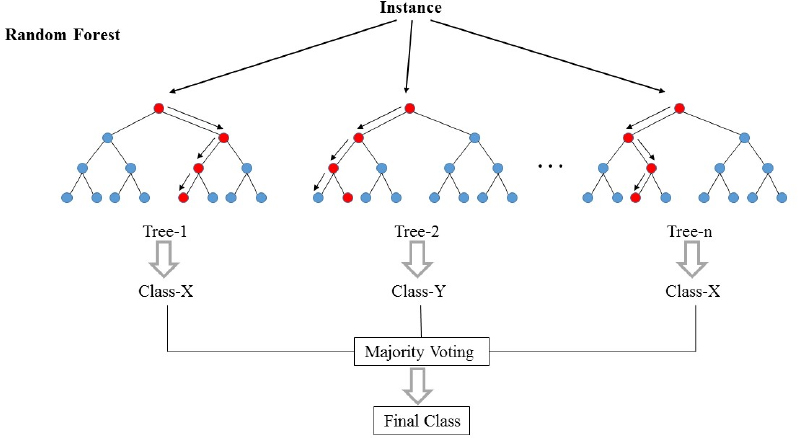

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
    
# from tqdm import tqdm
from tqdm.notebook import tqdm

## Carregando Base de Dados

In [2]:
!rm -r MLUD
!git clone https://github.com/Crissky/MLUD.git

rm: cannot remove 'MLUD': No such file or directory
Cloning into 'MLUD'...
remote: Enumerating objects: 336, done.
remote: Counting objects: 100% (336/336), done.
remote: Compressing objects: 100% (318/318), done.
remote: Total 336 (delta 147), reused 62 (delta 6), pack-reused 0
Receiving objects: 100% (336/336), 5.37 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (147/147), done.


## Funções de Pré-Processamento

Nessa aula, o vídeo mudou a maneira como são criadas as funções "Compute ‘método’ Model" e "Compute ‘método’ Example". Para facilitar a construção das funções, que são muito semelhantes, foi usada a abordagem de Orientação a Objetos.

No vídeo não é utilizado herança efetivamente, pois ele usa as funções diretamente da Classe que seria a “PAI” no lugar no “self” ou “super()” para evitar a necessidade de instância-lá.

Eu optei por usar as instâncias para realmente utilizar a herança. Outra mudança que fiz foi colocar a função “Compute Example” na Classe Pai (Classification Model), pois nos casos da Regressão Logística e do KNN, elas são idênticas.

Já a Classe do SVM precisa reescrever a função “Compute Example”, pois sua função “Compute Model” tem um argumento a mais, sendo que a “Compute Example” chama a “Compute Model”.


In [3]:
def loadDataset(filename, delimiter=';'):
    baseDeDados = pd.read_csv(filename, delimiter=delimiter)
    X = baseDeDados.iloc[:,:-1].values
    y = baseDeDados.iloc[:,-1].values

    return X, y, baseDeDados

def fillMissingData(X, inicioColuna, fimColuna):
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X[:,inicioColuna:fimColuna + 1] = imputer.fit_transform(X[:,inicioColuna:fimColuna + 1])

    return X

#só funciona se i = 0 ou i = ultima coluna
def computeCategorization(X):
    labelencoder_X = LabelEncoder()
    X[:, 0] = labelencoder_X.fit_transform(X[:, 0])

    #one hot encoding
    D = pd.get_dummies(X[:,0]).values
    
    X = X[:,1:]
    for ii in range(0, D.shape[1]):
        X = np.insert(X, X.shape[1], D[:,ii], axis=1)
    X = X[:,:X.shape[1] - 1]

    return X

def splitTrainTestSets(X, y, testSize):
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)

    return XTrain, XTest, yTrain, yTest

def computeScaling(X):
    scale = StandardScaler()
    X = scale.fit_transform(X)

    return X, scale

In [4]:
def printAccuracy(confunsionMatrix):
    accuracy = getAccuracy(confunsionMatrix)
    print('Confusion Matrix:\n', confunsionMatrix)
    print('Accuracy:', accuracy)

def getAccuracy(confunsionMatrix):
    accuracy = (confunsionMatrix[0][0] + confunsionMatrix[1][1])/ confunsionMatrix.sum()

    return (accuracy * 100)

In [5]:
class ClassificationModel:
    def predictModel(self, classifier, X):
        return classifier.predict(X)

    def evaluateModel(self, yPred, yTest):
        confusionMatrix = confusion_matrix(yTest, yPred)

        return confusionMatrix

    def preprocessData(self, filename, delimiter=','):
        X, y, csv = loadDataset(filename, delimiter)
        X = fillMissingData(X, 2, 3)
        X = computeCategorization(X)
        X = computeCategorization(X)
        XTrain, XTest, yTrain, yTest = splitTrainTestSets(X, y, 0.15)
        XTrain, XTrainScale = computeScaling(XTrain) # No vídeo está recebendo a tupla em uma única variável. Fazendo com que no classifier.fit, da função computeLogisticRegressionModel, o XTrain tenha que se passado desta maneira XTrain[0]
        XTest, XTestScale = computeScaling(XTest)

        return XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale
    
    def computeModel(self, XTrain, yTrain):
        pass

    def computeExample(self, filename, delimiter=','):
        XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale = self.preprocessData(filename, delimiter)

        classifier = self.computeModel(XTrain, yTrain)
        yPred = self.predictModel(classifier, XTest)

        return self.evaluateModel(yPred, yTest)

## Regressão Logística

In [6]:
class MyLogisticRegression(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = LogisticRegression(solver='lbfgs')
        classifier.fit(XTrain, yTrain)
        
        return classifier

## K-NN

In [7]:
class KNN(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = KNeighborsClassifier(n_neighbors=5, p=1)
        classifier.fit(XTrain, yTrain)
    
        return classifier

## SVM

In [8]:
class SVM(ClassificationModel):
    def computeModel(self, XTrain, yTrain, k, d=0):
        if (d <= 0):
            classifier = SVC(kernel=k)
        else:
            classifier = SVC(kernel=k, degree=d)
        classifier.fit(XTrain, yTrain)

        return classifier

    def computeExample(self, filename, kernel='linear', degree=0, delimiter=','):
        XTrain, XTest, yTrain, yTest, XTrainScale, XTestScale = self.preprocessData(filename, delimiter)

        classifier = self.computeModel(XTrain, yTrain, kernel, degree)
        yPred = self.predictModel(classifier, XTest)

        return self.evaluateModel(yPred, yTest)


## Naive Bayes

In [9]:
class NaiveBayes(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = GaussianNB()
        classifier.fit(XTrain, yTrain)

        return classifier


## Decision Tree

In [10]:
class DecisionTree(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = DecisionTreeClassifier(criterion='entropy')
        classifier.fit(XTrain, yTrain)

        return classifier


## Random Forest

In [11]:
class RandomForest(ClassificationModel):
    def computeModel(self, XTrain, yTrain):
        classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
        classifier.fit(XTrain, yTrain)

        return classifier

## Comparando Regressão Logística, KNN, SVM e Naive Bayes

O argumento "class_arguments" foi modificado para receber Listas no lugar de Tuplas, para evitar a necessidade do uso do IF quando o "class_arguments" possuir somente 1 "argumento".

In [12]:
def run_testing(n_loop, class_model, class_arguments, class_name=None, ncols=500, verbose=True):
    array = list()
    model = class_model()
    if(not class_name):
        class_name = type(class_model()).__name__
    for i in tqdm(range(n_loop), desc=class_name, ncols=ncols):        
        confunsionMatrix = model.computeExample(*class_arguments)
        
        array.append(getAccuracy(confunsionMatrix))
    
    if(verbose):
        print('Média da %s: %.2f' % (class_name, np.mean(array) ) )
        print('Desvio Padrão da %s: %.2f\n' % (class_name, np.std(array) ) )        

    return array


In [13]:
total_loops = 100
ncols=500

rlArray = run_testing(total_loops, MyLogisticRegression, ['MLUD/Aula13/titanic.csv'], 'Regressão Linear', ncols)
knnArray = run_testing(total_loops, KNN, ['MLUD/Aula13/titanic.csv'], 'KNN', ncols)
svmGaussArray = run_testing(total_loops, SVM, ['MLUD/Aula13/titanic.csv', 'rbf'], 'SVM Gaussiana', ncols)
nbArray = run_testing(total_loops, NaiveBayes, ['MLUD/Aula13/titanic.csv'], 'Naive Bayes', ncols)
dtArray = run_testing(total_loops, DecisionTree, ['MLUD/Aula13/titanic.csv'], 'Decision Tree', ncols)
rfArray = run_testing(total_loops, RandomForest, ['MLUD/Aula13/titanic.csv'], 'Random Forest', ncols)


Média da Regressão Linear: 80.31
Desvio Padrão da Regressão Linear: 3.26




Média da KNN: 79.54
Desvio Padrão da KNN: 3.56




Média da SVM Gaussiana: 82.18
Desvio Padrão da SVM Gaussiana: 3.14




Média da Naive Bayes: 77.69
Desvio Padrão da Naive Bayes: 3.44




Média da Decision Tree: 70.34
Desvio Padrão da Decision Tree: 6.51




Média da Random Forest: 73.41
Desvio Padrão da Random Forest: 5.55



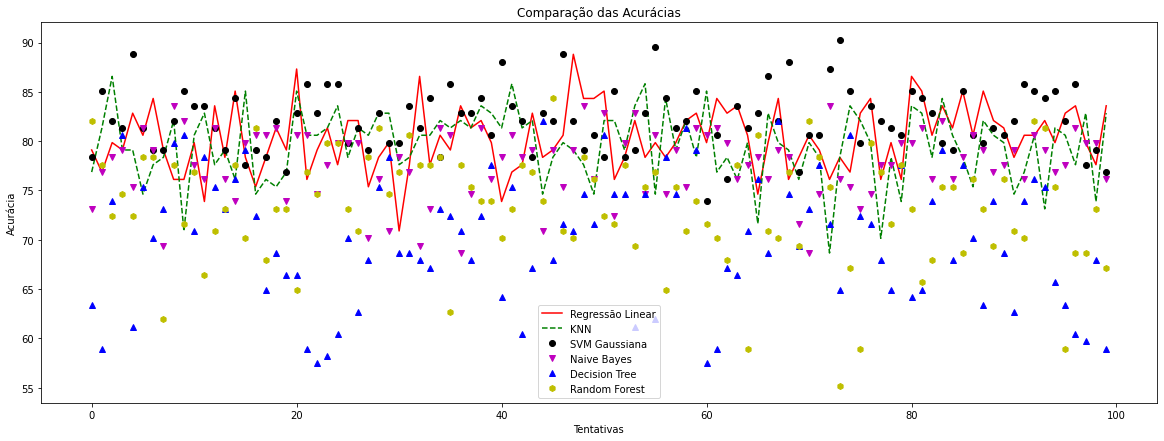

In [14]:
plt.figure(figsize=(20, 7))
plt.plot(rlArray, 'r-', label='Regressão Linear')
plt.plot(knnArray, 'g--', label='KNN')
plt.plot(svmGaussArray, 'ko', label='SVM Gaussiana')
plt.plot(nbArray, 'mv', label='Naive Bayes')
plt.plot(dtArray, 'b^', label='Decision Tree')
plt.plot(rfArray, 'yh', label='Random Forest')
plt.xlabel('Tentativas')
plt.ylabel('Acurácia')
plt.title('Comparação das Acurácias')
plt.legend()
plt.show()